# Part II Project Notebook

## Extraction of Normal Modes and Plotting

In [47]:
%load_ext autoreload
%autoreload 2

In [48]:
from src.springcraft_NMA import calculate_normal_modes_gnm_from_file

gnm = calculate_normal_modes_gnm_from_file("./1a0a.pdb", 10.0)
eigenval,eigenvec = gnm.eigen()
eigenval,eigenvec

FileNotFoundError: [Errno 2] No such file or directory: './1a0a.pdb'

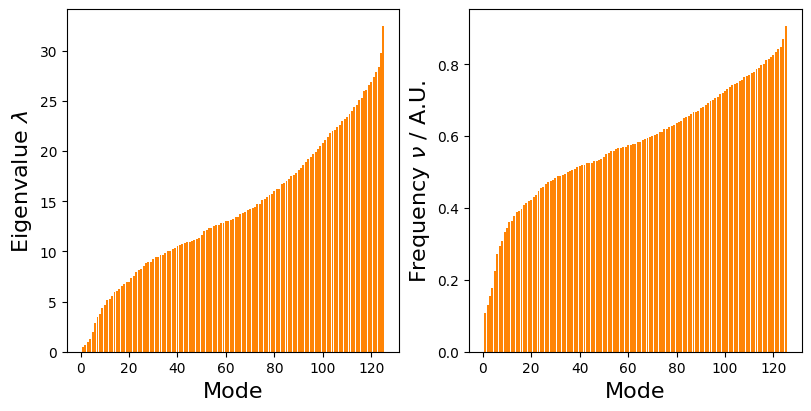

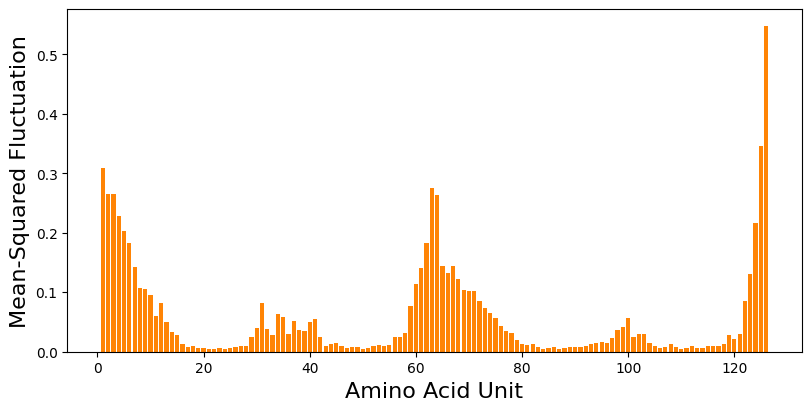

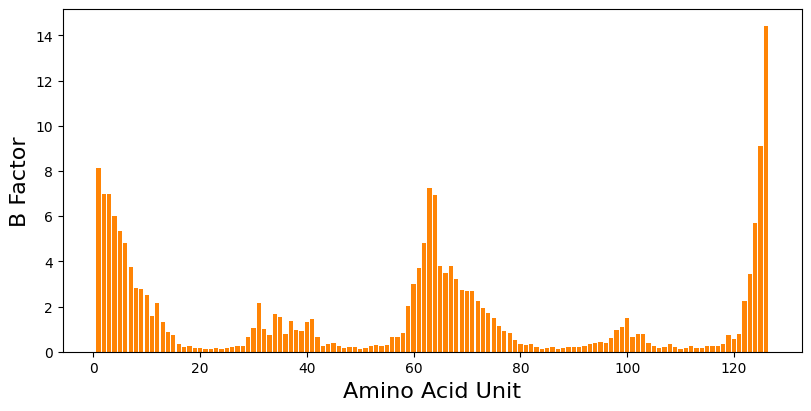

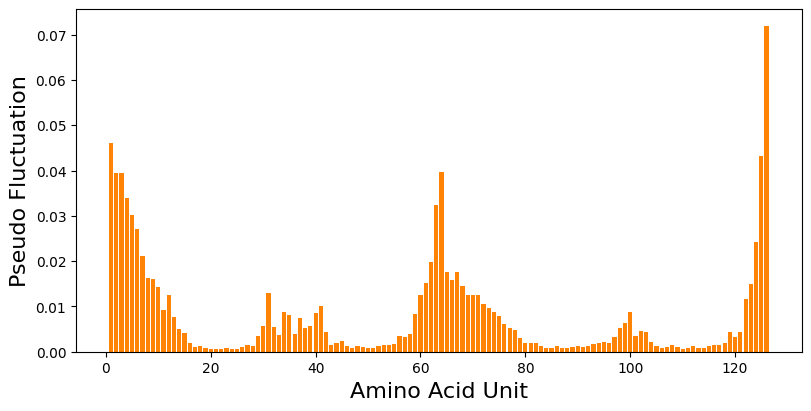

In [52]:
from src.springcraft_NMA import plot_flexibility_value, plot_eigval_freq

plot_eigval_freq("1A0A", 10.0)
plot_flexibility_value("1A0A", 10.0, 10, "msqf")
plot_flexibility_value("1A0A", 10.0, 10, "bfact")
plot_flexibility_value("1A0A", 10.0, 10, "pseudo")

## Data Preparation for Training Phase

In [4]:
import torch
from src.data_preprocessing import DataPreProcessorForGNM
x = DataPreProcessorForGNM(type_flexibility = "msqf")
torch.save(x.from_file("./1a0a.pdb"), "./data/preprocessed_data/1aar.pt")
torch.load("./data/preprocessed_data/bfact/0/1gqn_A.pt")

Data(x=[252, 3], edge_index=[2, 4594], y=[384], node_type=[252, 25], node_s=[252, 7], node_v=[252, 3, 3], edge_s=[4594, 32], edge_v=[4594, 1, 3], mask=[252])

## Loading Data

In [1]:
from libraries.lmdb_dataset import LMDBDataset

database = LMDBDataset("./data/pdb_data")
database

LMDBDataset(c:\Users\Mihailo\Desktop\Cambridge Part II\Part II Project\Part-II-Project-Protein-Dynamics-and-Flexibility\data\pdb_data)
	name:          pdb_data
	num_examples:  54,899
	size_on_disk:  3,648.76 MB

In [6]:
from src.data_loaders import load_labels

labels = load_labels("./data/domain_data/chain_functions.txt")
len((labels["label"]).unique())


6

In [7]:
from src.data_preprocessing import calculate_all_structures_and_store
import os

os.mkdir("./data/preprocessed_data_md")

nm = [2, 5, 10]

os.mkdir("./data/preprocessed_data_md/no_flex")

for i in nm:
    os.mkdir("./data/preprocessed_data_md/" + str(i))
    os.mkdir("./data/preprocessed_data_md/" + str(i) + "/msqf")
    os.mkdir("./data/preprocessed_data_md/" + str(i) + "/bfact")
    os.mkdir("./data/preprocessed_data_md/" + str(i) + "/pseudo")
    for j in range(0,6):
        os.mkdir("./data/preprocessed_data_md/" + str(i) + "/msqf/" + str(j))
        os.mkdir("./data/preprocessed_data_md/" + str(i) + "/pseudo/" + str(j))
        os.mkdir("./data/preprocessed_data_md/" + str(i) + "/bfact/" + str(j))

for j in range(0, 6):
    os.mkdir("./data/preprocessed_data_md/no_flex/" + str(j))

calculate_all_structures_and_store(labels, database, "./data/preprocessed_data_md", 6, None , None)

for i in nm:
    calculate_all_structures_and_store(labels, database, "./data/preprocessed_data_md/" + str(i), 6, "msqf", None, i)
    calculate_all_structures_and_store(labels, database, "./data/preprocessed_data_md/" + str(i), 6, "bfact", None, i)
    calculate_all_structures_and_store(labels, database, "./data/preprocessed_data_md/" + str(i), 6, "pseudo", None, i)

100%|██████████| 241/241 [00:42<00:00,  5.64it/s]


In [16]:
from tqdm import tqdm
from src.data_preprocessing import  DataPreProcessorForGNM
from src.data_preprocessing import is_chain_valid
import biotite.structure as struc
import warnings
warnings.filterwarnings("error")
flex = "msqf"

missing_ids = []
for id in tqdm(set(labels.chain_id)):
    PDBid, chain = id.split(".")
    if(PDBid in database):
        structure = database[PDBid]["structure"]
        x = DataPreProcessorForGNM(type_flexibility = flex, num_modes=10)
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(not is_chain_valid(protein_chain)):
            missing_ids.extend([id])
    else:
        missing_ids.extend([id])
len(missing_ids)

100%|██████████| 37426/37426 [06:38<00:00, 93.88it/s] 


1733

In [23]:
import pandas as pd
data1 = load_labels("./data/enzyme_data/splits/split0.txt")
data2 = load_labels("./data/enzyme_data/splits/split1.txt")

data = pd.concat([data1,data2])
data[~data.chain_id.isin(missing_ids)].label.value_counts()

357    750
23     443
351    409
215    350
178    319
      ... 
72       4
291      3
104      2
142      2
97       2
Name: label, Length: 384, dtype: int64

In [5]:
from src.data_loaders import ProteinDataset

training_structures = ProteinDataset(labels, "./data/enzyme_data/training.txt", "msqf", "./data/enzyme_data/missing_resis.txt")
testing_structures = ProteinDataset(labels, "./data/enzyme_data/testing.txt", "msqf", "./data/enzyme_data/missing_resis.txt")
validating_structures = ProteinDataset(labels, "./data/enzyme_data/validation.txt", "msqf", "./data/enzyme_data/missing_resis.txt")

  3%|▎         | 598/22836 [00:03<02:25, 152.91it/s]


KeyboardInterrupt: 

In [8]:
import torch
from tqdm import tqdm
torch.load("./data/preprocessed_data_md/2/msqf/0/1a48_A.pt")

Data(x=[305, 3], edge_index=[2, 4992], y=[6], node_type=[305, 25], node_s=[305, 7], node_v=[305, 3, 3], edge_s=[4992, 32], edge_v=[4992, 1, 3], mask=[305])

In [9]:
print(len(training_structures))
print(len(testing_structures))
print(len(validating_structures))

21671
3099
1316


## Running Experiments

In [10]:
import time
import random
import numpy as np

import torch

from torch_geometric.loader import DataLoader


In [11]:
def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [12]:
from torch.utils.data import Subset
train_loader = DataLoader(Subset(validating_structures, list(range(128))), batch_size=64, shuffle=False)
val_loader = DataLoader(Subset(validating_structures, list(range(128))), batch_size=64, shuffle=False)
test_loader = DataLoader(Subset(validating_structures, list(range(128))), batch_size=64, shuffle=False)

In [38]:
from src.models import EGNNSiLUModel, EGNNReLUModel
from src.experiment_utils import run_experiment

model = EGNNSiLUModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)

model = EGNNReLUModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)

Running experiment for EGNNSiLUModel, training on 128 samples for 100 epochs.

Device:
GPU

Model architecture:
EGNNSiLUModel(
  (lin_in): Linear(in_features=32, out_features=64, bias=True)
  (convs): ModuleList(
    (0): EGNNSiLULayer(emb_dim=64, aggr=add)
    (1): EGNNSiLULayer(emb_dim=64, aggr=add)
    (2): EGNNSiLULayer(emb_dim=64, aggr=add)
    (3): EGNNSiLULayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=384, bias=True)
)
Total parameters: 178628

Start training:


KeyboardInterrupt: 

In [13]:
from src.testing.unit_tests import permutation_equivariance_unit_test, permutation_invariance_unit_test, rot_trans_invariance_unit_test, rot_trans_equivariance_unit_test
from src.models import EGNNReLUModel, EGNNSiLUModel, EGNNReLULayer, EGNNSiLULayer
from torch.utils.data import Subset

# Instantiate temporary model, layer, and dataloader for unit testing
layer = EGNNReLULayer(emb_dim=32, edge_dim=32)
model = EGNNReLUModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384)
dataloader = DataLoader(Subset(validating_structures, list(range(64))), batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

# Rotation and translation invariance unit test for MPNN layer
print(f"Is {type(layer).__name__} rotation and translation equivariant? --> {rot_trans_equivariance_unit_test(layer, dataloader)}!")

# Instantiate temporary model, layer, and dataloader for unit testing
layer = EGNNSiLULayer(emb_dim=32, edge_dim=32)
model = EGNNSiLUModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384)
dataloader = DataLoader(Subset(validating_structures, list(range(64))), batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

# Rotation and translation invariance unit test for MPNN layer
print(f"Is {type(layer).__name__} rotation and translation equivariant? --> {rot_trans_equivariance_unit_test(layer, dataloader)}!")

Is EGNNReLUModel permutation invariant? --> True!
Is EGNNReLULayer permutation equivariant? --> True!
Is EGNNReLUModel rotation and translation invariant? --> True!
Is EGNNReLULayer rotation and translation equivariant? --> True!
Is EGNNSiLUModel permutation invariant? --> True!
Is EGNNSiLULayer permutation equivariant? --> True!
Is EGNNSiLUModel rotation and translation invariant? --> True!
Is EGNNSiLULayer rotation and translation equivariant? --> True!


In [1]:
import pytorch_lightning as pl
from src.pl_models import PlEGNNModel,EGNNDataModule
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch

wandb_logger = WandbLogger(name='SiLU_MD_pseudo_k_10_lr_1e-4_rd_98_without_fold_3', project='Testing')

early_stop_callback = EarlyStopping(monitor="val_macro_f1", min_delta=0.00, patience=25, verbose=False, mode="max")
checkpoint_callback = ModelCheckpoint(
    save_top_k=5,
    monitor="val_macro_f1",
    mode="max",
    dirpath="Cross_Checkpoints/MD/",
    filename="pseudo_k_10_without_fold_3-{epoch:02d}-{val_macro_f1:.2f}",
)

trainer = pl.Trainer(max_epochs=200, accelerator="gpu", logger = wandb_logger, callbacks=[checkpoint_callback, early_stop_callback])
model = PlEGNNModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=6, num_classes=6)
datamodule = EGNNDataModule(flex = "pseudo", num_workers = 4, without_fold=3, num_folds=4,store_data="./data/preprocessed_data_md/10",batch_size=4, labels_dir="./data/domain_data/")

trainer.fit(model, datamodule = datamodule)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mm2507. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


100%|██████████| 57/57 [00:00<00:00, 622.71it/s]
C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\Users\Mihailo\Desktop\Cambridge Part II\Part II Project\Part-II-Project-Protein-Dynamics-and-Flexibility\Cross_Checkpoints\MD exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | lin_in    | Linear             | 2.1 K 
1 | convs     | ModuleList         | 151 K 
2 | lin_pred  | Linear             | 390   
3 | train_f1  | MulticlassF1Score  | 0     
4 | train_acc | MulticlassAccuracy | 0     
5 | val_f1    | MulticlassF1Score  | 0     
6 | val_acc   | MulticlassAccuracy | 0     
7 | test_f1   | MulticlassF1Score  | 0     
8 | t

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [1]:
import pytorch_lightning as pl
from src.pl_models import PlEGNNModel,EGNNDataModule
import torch
trainer = pl.Trainer(max_epochs=100, accelerator="gpu")
model=PlEGNNModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384, num_classes=384,activation=torch.nn.SiLU)
datamodule = EGNNDataModule(flex = "msqf", num_workers = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [2]:
trainer.test(model, ckpt_path="./SiLUCheckpoints/msqf_k_5-epoch=109-val_macro_f1=0.51.ckpt", datamodule = datamodule)

100%|██████████| 5651/5651 [00:32<00:00, 173.69it/s]
Restoring states from the checkpoint path at ./SiLUCheckpoints/msqf_k_5-epoch=109-val_macro_f1=0.51.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./SiLUCheckpoints/msqf_k_5-epoch=109-val_macro_f1=0.51.ckpt
C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (19791x31 and 32x64)

In [6]:
from src.data_loaders import ProteinDataset
from src.data_loaders import load_labels

labels = load_labels("./data/enzyme_data/chain_functions.txt")

training_structures = ProteinDataset(labels, "./data/enzyme_data/training.txt", "msqf")
testing_structures = ProteinDataset(labels, "./data/enzyme_data/testing.txt", "msqf")
validating_structures = ProteinDataset(labels, "./data/enzyme_data/validation.txt", "msqf")

100%|██████████| 2562/2562 [00:12<00:00, 213.15it/s]


In [9]:
import numpy as np
from tqdm import tqdm
classes = np.zeros(384)

for protein in tqdm(testing_structures):
    classes[protein.y.argmax()]+=1

classes

 33%|███▎      | 1015/3099 [00:04<00:09, 229.88it/s]


KeyboardInterrupt: 

In [1]:
from src.data_loaders import load_labels

labels = load_labels("./data/enzyme_data/chain_functions.txt")
len((labels["label"]).unique())

384

In [2]:
from libraries.pdb import RcsbPdbClusters
import pandas as pd
from tqdm import tqdm
from src.data_preprocessing import  DataPreProcessorForGNM
from src.data_preprocessing import is_chain_valid
import biotite.structure as struc
import warnings
from libraries.lmdb_dataset import LMDBDataset
import os
from src.data_loaders import load_labels


In [3]:
database = LMDBDataset("./data/pdb_data")

warnings.filterwarnings("error")
flex = "msqf"

missing_ids = []
for id in tqdm(set(labels.chain_id)):
    PDBid, chain = id.split(".")
    if(PDBid in database):
        structure = database[PDBid]["structure"]
        x = DataPreProcessorForGNM(type_flexibility = flex, num_modes=10)
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(not is_chain_valid(protein_chain)):
            missing_ids.extend([id])
    else:
        missing_ids.extend([id])
len(missing_ids)

100%|██████████| 37426/37426 [07:10<00:00, 86.88it/s] 


1733

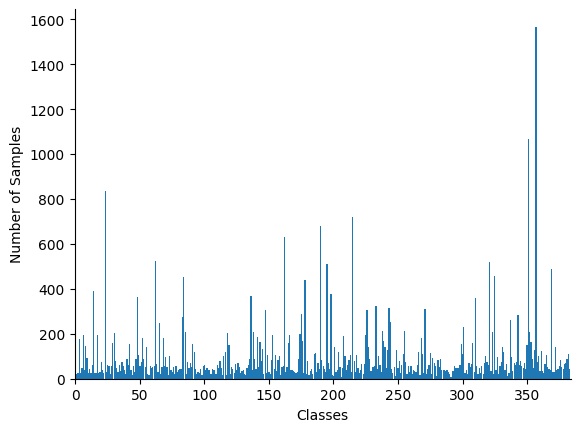

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

data = labels.groupby(by="label").count()

ax = data.plot.bar(y='chain_id', width=0.95)
ax.set_xticks([0, 50, 100, 150, 200, 250, 300, 350])
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.get_legend().remove()
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.show()

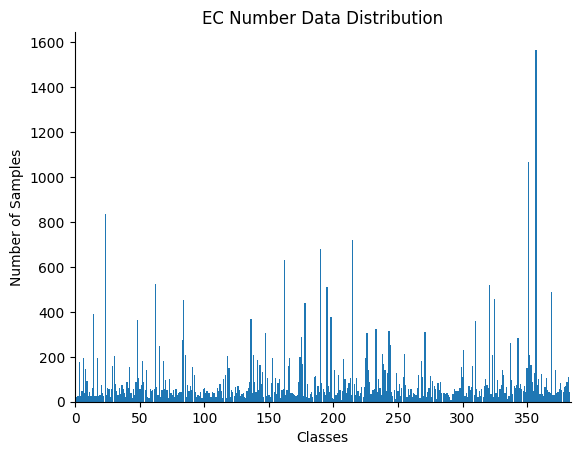

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

data = labels[~labels.chain_id.isin(missing_ids)].groupby(by="label").count()

ax = data.plot.bar(y='chain_id', width=0.95)
ax.set_xticks([0, 50, 100, 150, 200, 250, 300, 350])
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.get_legend().remove()
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("EC Number Data Distribution")
plt.show()

In [36]:
df = pd.read_csv('./data/domain_data/structural_rearrangement_data.csv')
df.head()

,Unnamed: 0,level_0,index,PSCID,Protein Name,Free form,Bound form,Ligands,Classification(?),motion_type,Free PDB,Free Chains,Bound PDB,Bound Chains
0,0,0,0,CD.1,HYPOTHETICAL OXIDOREDUCTASE YIAK,1nxu_AB,1s20_AB,"2xNAD,2xTLA",200004,coupled_domain_motion,1nxu,AB,1s20,AB
1,1,1,1,CD.2,ADENYLATE KINASE,4ake_A,2eck_A,"ADP,AMP",200003,coupled_domain_motion,4ake,A,2eck,A
2,2,2,2,CD.3,GLUCOKINASE,1q18_AB,1sz2_AB,2xBGC,200003,coupled_domain_motion,1q18,AB,1sz2,AB
3,3,3,3,CD.4,LACTOFERRIN,1lfh_A,1lfi_A,"2xCU,2xNAG",110103,coupled_domain_motion,1lfh,A,1lfi,A
4,4,4,4,CD.5,ELONGATION FACTOR 2,1n0v_D,1n0u_A,SO1,110002,coupled_domain_motion,1n0v,D,1n0u,A


In [37]:
df['classes'] = df['motion_type'].replace({"coupled_domain_motion": 0, "independent_domain_motion":1, "independent_local_motion":2, "burying_ligand_motion":3 , 'coupled_local_motion':4, "no_significant_motion":5, "other_motion":6})
important_df = df[["Free PDB", "Free Chains", "classes"]]

In [38]:
important_df = important_df.drop(important_df[important_df.classes==6].index)
important_df = important_df.drop_duplicates(subset=["Free Chains", "Free PDB"], keep = False)

In [39]:
important_df = important_df.loc[important_df["Free Chains"].str.len() == 1]
important_df.head()

,Free PDB,Free Chains,classes
1,4ake,A,0
3,1lfh,A,0
4,1n0v,D,0
6,2p0m,A,0
7,3cze,A,0


In [40]:
database = LMDBDataset("./data/pdb_data")

warnings.filterwarnings("error")
flex = "msqf"

important_df["chain_id"] = important_df["Free PDB"] + "." + important_df["Free Chains"]

missing_ids = []
for id in tqdm(set(important_df.chain_id)):
    PDBid, chain = id.split(".")
    if(PDBid in database):
        structure = database[PDBid]["structure"]
        x = DataPreProcessorForGNM(type_flexibility = flex, num_modes=10)
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(not is_chain_valid(protein_chain)):
            missing_ids.extend([id])
    else:
        missing_ids.extend([id])
len(missing_ids)

100%|██████████| 497/497 [00:02<00:00, 189.65it/s]


256

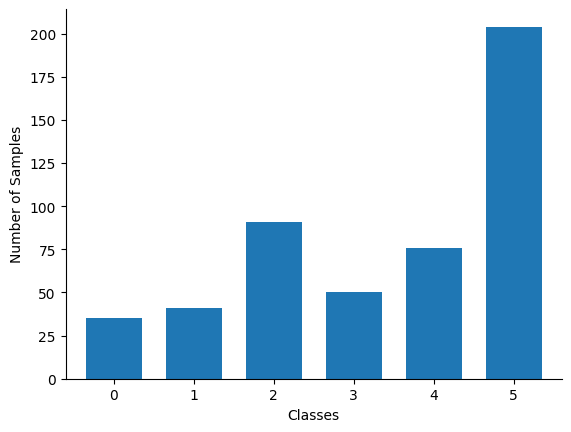

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

data = important_df.groupby(by="classes").count()

ax = data.plot.bar(y='chain_id', width=0.7)
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.get_legend().remove()
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.show()

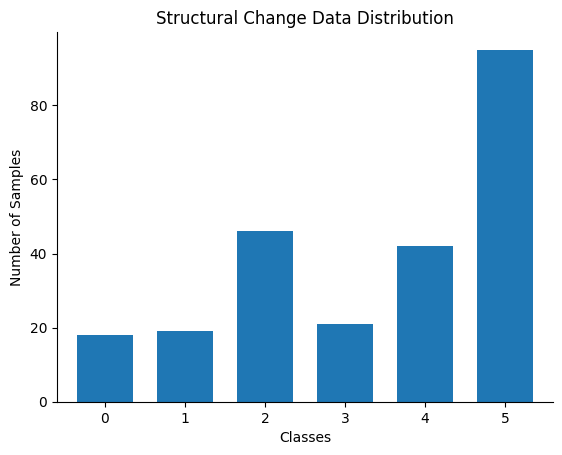

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

data = important_df[~important_df.chain_id.isin(missing_ids)].groupby(by="classes").count()

ax = data.plot.bar(y='chain_id', width=0.7)
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.get_legend().remove()
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Structural Change Data Distribution")
plt.show()